## setting 
- 1. In the menu bar, select Runtime -> Change Runtime Type. Set runtime as gpu
- 2. Sync Shirley's APS 490 folder in your drive.

## import data

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
!pip install torch==1.10.0
import torch.nn as nn
import torch
import numpy as np
from tqdm.notebook import tqdm as tqdm
import os

# folder_path = r'C:\Users\chuiy\Documents\CPPIB 17th Floor_20211014-153532'
# savefile_path = r'C:\Users\chuiy\Documents\merged_data'
folder_path = r'/content/drive/MyDrive/APS490/Datasets/CPPIB 17th Floor_20211014-153532'
savefile_path = r'/content/drive/MyDrive/APS490/Datasets/'
savefile_name = r'merge_CPPIB_17th.csv'

slash = '/'

if not os.path.exists(savefile_path+slash+ savefile_name):
  os.chdir(folder_path)
  file_list = []
  for file_name in os.listdir():
    if file_name.endswith(".csv"):
      file_list.append(file_name)

  df = pd.read_csv(folder_path +slash+ file_list[0])
  df.to_csv(savefile_path+slash+ savefile_name,encoding="utf_8_sig",index=False)
  for i in range(1,len(file_list)):
      df = pd.read_csv(folder_path + slash+ file_list[i])
      df.to_csv(savefile_path+slash+ savefile_name,encoding="utf_8_sig",index=False, header=False, mode='a+')
else:
  print("File already exists. Loaded data from CSV")


File already exists. Loaded data from CSV


In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [52]:
file_name = savefile_path + slash+ savefile_name
date = 'DateTime'
input1 = 'Modern Niagara > CPPIB > 17th Flr > CU-17-01 _ 1723 Mechanical Room > Supply Fan.Speed'
input2 = 'Modern Niagara > CPPIB > 17th Flr > CU-17-01 _ 1723 Mechanical Room > Discharge Air.Static Pressure'
# dataset file name
whole_data = pd.read_csv(file_name)
selected_raw_data = pd.read_csv(file_name)[[input1, input2]]


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,14,16,30,44,58,72,86,100,114,128,142,156,170,184,198,212,226,240,254,268,282,296,310,324,338,352,366,380,394,408,422,436,450,464,478,492,506,520,534,548,562,576,590,604) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## GPU info

In [53]:
!nvidia-smi 

Fri Nov 26 09:26:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    36W / 250W |   1049MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## curve of parameter
** just have a glance at data. it is not related to other parts of codes

Text(0.5, 1.0, 'static pressure in CU from Feb 1 to Oct 14')

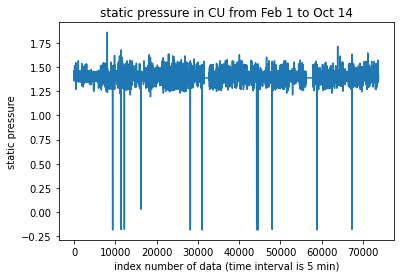

In [54]:

plt.plot(whole_data[input2])
plt.ylabel("static pressure")
plt.xlabel("index number of data (time interval is 5 min)")
plt.title("static pressure in CU from Feb 1 to Oct 14")


Text(0.5, 1.0, 'fan speed in CU from Feb 1 to Oct 14')

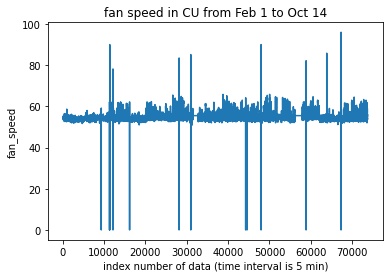

In [55]:
plt.plot(whole_data[input1])
plt.ylabel("fan_speed")
plt.xlabel("index number of data (time interval is 5 min)")
plt.title("fan speed in CU from Feb 1 to Oct 14")

## set size of train and test data

In [65]:
start_index = 0
train_data_size = 40000
batch_size = 25
selected_raw_data = selected_raw_data.astype(float)
train_data = np.asarray(selected_raw_data[start_index:start_index+train_data_size])
test_data = np.asarray(selected_raw_data[start_index+train_data_size:int(start_index+1.4*train_data_size)])


## normalize data 
** i set the range from -1 to 1 here

## sample LSTM model

In [66]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 2))
test_data_normalized = scaler.fit_transform(test_data.reshape(-1, 2))
print(train_data_normalized)

[[       nan 0.55076921]
 [       nan 0.52615392]
 [       nan 0.55076921]
 ...
 [0.28888889 0.55076921]
 [0.28888889 0.52615392]
 [0.28888889 0.54461538]]


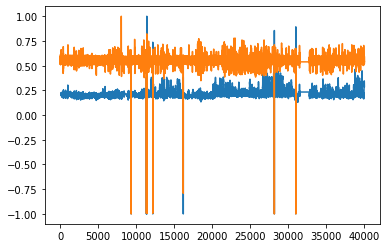

In [67]:
plt.plot(train_data_normalized)

In [68]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1, 2)
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1, 2)
train_data_normalized

tensor([[   nan, 0.5508],
        [   nan, 0.5262],
        [   nan, 0.5508],
        ...,
        [0.2889, 0.5508],
        [0.2889, 0.5262],
        [0.2889, 0.5446]])

## Prepare data

In [69]:
# 1st iteration: ( first 200(train_window) data) -> next 12 data (predicting window)
# 2nd iteration:       (data2, data3, ..., 200th, 201th) -> next 12 data (predicting window)
# ...
train_window = 200
predicting_window = 12
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    input_data[input_data != input_data] = -100 # setting missing data as 'none'
    for i in range(0, L-tw, predicting_window):
        valid = True
        for data_point in input_data[i:i+tw+predicting_window]:
          for data in data_point:
            if data <-1:
              valid = False

        seq = input_data[i:i+tw]
        label = input_data[i+tw:i+tw+predicting_window][:, [1]]
        if valid:
          inout_seq.append((seq ,label)) 
    return inout_seq[:-1]

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
test_inout_seq = create_inout_sequences(test_data_normalized, train_window)
print(train_inout_seq[0])
# def get_batch_data(data, batch_size):
#   result = []
#   max_length = len(data) // batch_size + 1 if len(data) % batch_size > 0 else len(data) // batch_size
#   for i in range(batch_size):
#     if i + 1 == batch_size:
#       result.append(data[i*max_length:])
#     else:
#       result.append(data[i*max_length: (i+ 1)*max_length])
#   result = np.asarray(result)
#   return result

# train_inout_seq = get_batch_data(train_inout_seq, batch_size)
# test_inout_seq = get_batch_data(test_inout_seq, ba)


(tensor([[0.2000, 0.5262],
        [0.2000, 0.5323],
        [0.2000, 0.5200],
        [0.2000, 0.5446],
        [0.2259, 0.5815],
        [0.2037, 0.5446],
        [0.2037, 0.5200],
        [0.2037, 0.5508],
        [0.2037, 0.5323],
        [0.2259, 0.6000],
        [0.2000, 0.5323],
        [0.2000, 0.5754],
        [0.1963, 0.5262],
        [0.2185, 0.5692],
        [0.2185, 0.5692],
        [0.1963, 0.5200],
        [0.2222, 0.5508],
        [0.2000, 0.5446],
        [0.2222, 0.5385],
        [0.2000, 0.5446],
        [0.2000, 0.5385],
        [0.2259, 0.5631],
        [0.1963, 0.5446],
        [0.2185, 0.5508],
        [0.2111, 0.5692],
        [0.2074, 0.5692],
        [0.2074, 0.5569],
        [0.2074, 0.5569],
        [0.2296, 0.5754],
        [0.2074, 0.5754],
        [0.2074, 0.5262],
        [0.2074, 0.5569],
        [0.2074, 0.5569],
        [0.2074, 0.5446],
        [0.2074, 0.5692],
        [0.2296, 0.5754],
        [0.2037, 0.5631],
        [0.2037, 0.5200],
        [0.

In [70]:
## input_size : number of input parameter
## hidden_layer_size : to tune
## output_size: number of output parameter

# class LSTM(nn.Module):
#     def __init__(self,batch_size=2,input_dim=2, hidden_dim=64, output_dim =1, num_layers=1):
#         super(LSTM, self).__init__()
#         self.input_dim = input_dim
#         self.hidden_dim = hidden_dim
#         self.batch_size = batch_size
#         self.num_layers = num_layers

#         # Define the LSTM layer
#         self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

#         # Define the output layer
#         self.linear = nn.Linear(self.hidden_dim, output_dim)

#     def init_hidden(self):
#         # This is what we'll initialise our hidden state as
#         return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
#                 torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

#     def forward(self, input):
#         # Forward pass through LSTM layer
#         # shape of lstm_out: [input_size, batch_size, hidden_dim]
#         # shape of self.hidden: (a, b), where a and b both 
#         # have shape (num_layers, batch_size, hidden_dim).
#         lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
#         # Only take the output from the final timetep
#         # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
#         y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
#         return y_pred.view(-1)

class LSTM(nn.Module):
    def __init__(self, input_size=2, hidden_layer_size=100, output_size=1, num_layers=2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        #self.hidden_cell = (torch.zeros(2,1,self.hidden_layer_size),
        #                    torch.zeros(2,1,self.hidden_layer_size))

    def forward(self, input_seq):
        input_seq = input_seq.cuda()
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[len(predictions) - 12:]


In [71]:
def get_batch_data(data, batch_size):
  result = []
  max_length = len(data) // batch_size + 1 if len(data) % batch_size > 0 else len(data) // batch_size
  for i in range(batch_size):
    if i + 1 == batch_size:
      result.append(data[i*max_length:])
    else:
      result.append(data[i*max_length: (i+ 1)*max_length])
  #result = np.asarray(result)
  return result
data_total = len(train_inout_seq)
train_inout_seq = get_batch_data(train_inout_seq, batch_size)

In [72]:


epochs = 10
model = LSTM()
model.to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss()

for i in tqdm(range(epochs)):
  y_train_pred_list = torch.tensor([]).to('cuda')
  y_train_true_list = torch.tensor([]).to('cuda')
  for b in tqdm(range(batch_size)):
    count = 0
    for seq, labels in train_inout_seq[b]:
      seq =seq.cuda()
      labels = labels.cuda()
      optimizer.zero_grad()
      model.hidden_cell = (torch.zeros(2, 1, model.hidden_layer_size,device=seq.device), torch.zeros(2, 1, model.hidden_layer_size,device=seq.device))
      y_pred = model(seq)
      # if len(y_pred) != len(labels):
      #   print(y_pred, labels)
      single_loss = loss_function(y_pred, labels)
      single_loss.backward()
      optimizer.step()

      y_train_pred_list = torch.cat((y_train_pred_list,y_pred))
      y_train_true_list = torch.cat((y_train_true_list,labels))
      # print(single_loss.item(), b, count)
      # count += 1


  print(f'epoch: {i:1} training loss: {single_loss.item():10.8f}')

  y_validation_pred_list = torch.tensor([]).to('cuda')
  y_validation_true_list = torch.tensor([]).to('cuda')
  for seq, labels in test_inout_seq:
    with torch.no_grad():
      seq =seq.cuda()
      labels = labels.cuda()
      y_pred = model(seq)
      single_loss = loss_function(y_pred, labels)
      y_validation_pred_list = torch.cat((y_validation_pred_list,y_pred))
      y_validation_true_list = torch.cat((y_validation_true_list,labels))
  print(f'epoch: {i:1} validation loss: {single_loss.item():10.8f}')




  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

epoch: 0 training loss: 0.00032554
epoch: 0 validation loss: 0.04281126


  0%|          | 0/25 [00:00<?, ?it/s]

epoch: 1 training loss: 0.00029404
epoch: 1 validation loss: 0.04281777


  0%|          | 0/25 [00:00<?, ?it/s]

epoch: 2 training loss: 0.00027917
epoch: 2 validation loss: 0.04233660


  0%|          | 0/25 [00:00<?, ?it/s]

epoch: 3 training loss: 0.00027452
epoch: 3 validation loss: 0.04170934


  0%|          | 0/25 [00:00<?, ?it/s]

epoch: 4 training loss: 0.00027429
epoch: 4 validation loss: 0.04119567


  0%|          | 0/25 [00:00<?, ?it/s]

epoch: 5 training loss: 0.00027632
epoch: 5 validation loss: 0.04075493


  0%|          | 0/25 [00:00<?, ?it/s]

epoch: 6 training loss: 0.00027760
epoch: 6 validation loss: 0.04056805


  0%|          | 0/25 [00:00<?, ?it/s]

epoch: 7 training loss: 0.00027875
epoch: 7 validation loss: 0.04042110


  0%|          | 0/25 [00:00<?, ?it/s]

epoch: 8 training loss: 0.00027881
epoch: 8 validation loss: 0.04033521


  0%|          | 0/25 [00:00<?, ?it/s]

epoch: 9 training loss: 0.00027930
epoch: 9 validation loss: 0.04032985


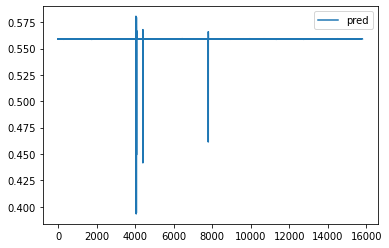

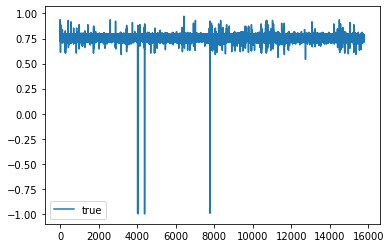

In [82]:


y_validation_pred_list = y_validation_pred_list.cpu()
y_validation_true_list = y_validation_true_list.cpu()
plt.plot(y_validation_pred_list, label="pred")
#plt.plot(y_validation_true_list, label="true")
plt.legend()
plt.show()
plt.plot(y_validation_true_list, label="true")
plt.legend()
plt.show()